# 75.06/95.58 Organización de Datos
# Análisis exploratorio: Real or Not? NLP with Disaster Tweets

### Carga de librerías

In [1]:
import pandas as pd

import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS #conda install -c conda-forge wordcloud 
from  imageio import imread
import nltk, os, re, string, collections
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
import squarify # pip install squarify
from PIL import Image
import multidict as multidict #pip install multidict
from pywaffle import Waffle #pip install pywaffle
import itertools
import csvtomd
import re
%matplotlib inline

### Carga de datos
Debido a que se trabajara con grandes cantidades de data, se definió convenientemente los tipos de datos de los datos pasados por archivo para no sobrecargar al parser de los archivos csv y ahorrar espacio de memoria.

#### Archivo sample

In [2]:
sample = pd.read_csv("sample_submission.csv")
# Se observa que es un data frame que sólo contiene informacion sobre los ids

#### Archivo test

In [3]:
dtype_test = {"id": np.int32, "keyword": "category"}
test = pd.read_csv("test.csv", dtype = dtype_test)

#### Archivo train

In [4]:
dtype_train = {"id": np.int32, "keyword": "category", "target" : bool}
train = pd.read_csv("train.csv", dtype = dtype_train, encoding='UTF_8')

# Limpieza de datos

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        7613 non-null   int32   
 1   keyword   7552 non-null   category
 2   location  5080 non-null   object  
 3   text      7613 non-null   object  
 4   target    7613 non-null   bool    
dtypes: bool(1), category(1), int32(1), object(2)
memory usage: 172.8+ KB


In [6]:
#vemos cuantos nulos hay por columna
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
#porcentaje de datos faltantes
((train.isnull().sum() / len(train))*100).sort_values(ascending=False)

location    33.272035
keyword      0.801261
target       0.000000
text         0.000000
id           0.000000
dtype: float64

## 1. Limpieza campo 'keyword'

In [8]:
#analizo los valores que llegan en 'keyword'
train.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
#armo lista con los keywords que ya existen
train_sin_keywords_nulos = train.dropna(subset=['keyword'])
np.unique(train_sin_keywords_nulos.keyword)

array(['ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'derailed

In [10]:
#limpio los que tienen "%20", parece que deberia ir un espacio ahi
train["keyword"] = train["keyword"].str.replace('%20',' ')
train_sin_keywords_nulos = train.dropna(subset=['keyword'])
keywords = np.unique(train_sin_keywords_nulos.keyword)
keywords

array(['ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown up', 'body bag', 'body bagging', 'body bags',
       'bomb', 'bombed', 'bombing', 'bridge collapse',
       'buildings burning', 'buildings on fire', 'burned', 'burning',
       'burning buildings', 'bush fires', 'casualties', 'casualty',
       'catastrophe', 'catastrophic', 'chemical emergency', 'cliff fall',
       'collapse', 'collapsed', 'collide', 'collided', 'collision',
       'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge',
       'deluged', 'demolish', 'demolished', 'demolition', 'derail',
       'derailed', 'derailment', 'desolate',

In [11]:
#miro los tweets que vienen sin keyword
train[train['keyword'].isnull()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,True
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,True
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,True
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,True
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,True
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,True
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,True
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,True


In [12]:
#completo aquellos que en el texto contengan alguna palabra de la lista keywords
for keyword in keywords:
    train.loc[(train['text'].str.contains(keyword, case=False) & train['keyword'].isnull()), 'keyword'] = keyword

In [13]:
#no se si convendria hacer fillna o no
train[train['keyword'].isnull()]
#df.fillna(value={'keyword': ''})

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,False
16,24,NaN,NaN,I love fruits,False
17,25,NaN,NaN,Summer is lovely,False
18,26,NaN,NaN,My car is so fast,False
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,False
20,31,NaN,NaN,this is ridiculous....,False
21,32,NaN,NaN,London is cool ;),False
22,33,NaN,NaN,Love skiing,False
23,34,NaN,NaN,What a wonderful day!,False
24,36,NaN,NaN,LOOOOOOL,False


In [14]:
train.keyword.value_counts()

fatalities             45
fire                   44
armageddon             42
earthquake             42
siren                  42
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword, Length: 221, dtype: int64

In [15]:
train.keyword.isnull().sum()

16

## Limpieza campo 'location'

In [16]:
len(train['location']) - train['location'].isnull().sum()

5080

In [17]:
#Veo la calidad de los que hay
#pd.set_option('display.max_rows', 20)
train['location'].value_counts()

USA                  104
New York              71
United States         50
London                45
Canada                29
                    ... 
dundalk ireland        1
Everett, WA            1
Jammu and Kashmir      1
Idaho                  1
Patra-Greece.          1
Name: location, Length: 3341, dtype: int64

In [18]:
#Creo que no tiene mucho sentido usar esta información más que para algún análisis de la cantidad de tweets con 
#location..
#Lo unico que se me ocurre que no se si tiene mucho sentido es mergear con algun set de datos de ciudades 
#(sacando los que tengan solo una aparicion)

# Análisis de datos

## 1. Análisis palabras y caracteres especiales

### 1.1 Análisis de distribuciones

In [19]:
#Funciones auxiliares
stopword = stopwords.words('english')

def stop(text):
    return [w for w in text.split() if w in stopword]
def length(text):
    return(np.mean([len(w) for w in text.split()]))
def punct(text):
    return [c for c in text if c in string.punctuation]
def title(text):
    return [w for w in text.split() if w.istitle()]
def upper_list(text):
    return [w for w in text.split() if w.isupper()]
def lower_list(text):
    return [w for w in text.split() if w.islower()]

Creo un data frame al que le cálculo ciertas cantidades.

In [20]:
palabras = train[["target"]].copy()

In [21]:
#Agrego funcion para contar silabas

def syllables(text):
    count = 0
    vowels = 'aeiouy'
    for word in text:
        word= word.lower()
        if word[0] in vowels:
            count +=1
        for index in range(1,len(word)):
            if word[index] in vowels and word[index-1] not in vowels:
                count +=1
        if word.endswith('e'):
            count -= 1
        if word.endswith('le'):
            count+=1
        if count == 0:
            count +=1
    return count

In [22]:
# Saco los links

def quitar_link_twitter(tweet):
    res = []
    for w in tweet.split(" "):
        if (("http" not in w) and ("https" not in w)):
            res.append(w)
    return (" ").join(res)


palabras['text'] = train['text'].apply(lambda x: quitar_link_twitter(x))

In [23]:
# Saco menciones

def quitar_mencion_twitter(tweet):
    res = []
    for w in tweet.split(" "):
        if("@" not in w):
            res.append(w)
    return (" ").join(res)


palabras['text'] = train['text'].apply(lambda x: quitar_link_twitter(x))

In [24]:
palabras_list = [palabras]

for df in palabras_list:
    # Número de palabras usadas
    df['#palabras'] = df['text'].apply(lambda x: len(x.split()))

    # Número de palabras únicas
    df['#palabras_unicas'] =  df['text'].apply(lambda x: len(set(x.split())))

    # Número de caracteres
    df['#caracteres'] =  df['text'].apply(lambda x: len(x))

    # Número de stopwords
    df['#stopwords'] = df['text'].apply(lambda x: len(stop(x)))
    
    # Número de caracteres de puntuación
    df['#putuacion'] = df['text'].apply(lambda x: len(punct(x)))
    
    # Número de palabras Capitalizadas
    df['#capitalize'] = df['text'].apply(lambda x: len(title(x)))

    # Número de palabras MAYUSCULAS
    df['#mayusculas'] = df['text'].apply(lambda x: len(upper_list(x)))
        
    # Número de silabas
    df['#silabas'] = df['text'].apply(lambda x: syllables(x))
    
    # Promedio de longitud del tweet
    df['promedio_len_word'] = df['text'].apply(lambda x: length(x))

/home/anichu/Programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [25]:
palabras.head(3)

,target,text,#palabras,#palabras_unicas,#caracteres,#stopwords,#putuacion,#capitalize,#mayusculas,#silabas,promedio_len_word
0,True,Our Deeds are the Reason of this #earthquake M...,13,13,69,5,1,5,1,18,4.384615
1,True,Forest fire near La Ronge Sask. Canada,7,7,38,0,1,5,0,10,4.571429
2,True,All residents asked to 'shelter in place' are ...,22,20,133,9,3,2,0,26,5.090909


In [26]:
palabras_col = palabras.columns[2:2+8]
palabras_nombre_col = ["Cantidad de palabras", "Cantidad de palabras únicas", "Cantidad de caracteres",\
                       "Cantidad de stopwords","Cantidad de signos de puntuación","Cantidad de palabras capitalizadas",\
                       "Cantidad de palabras en mayusculas","Cantidad de sílabas"]

Gráfico de distribuciones de data sobre los tweets

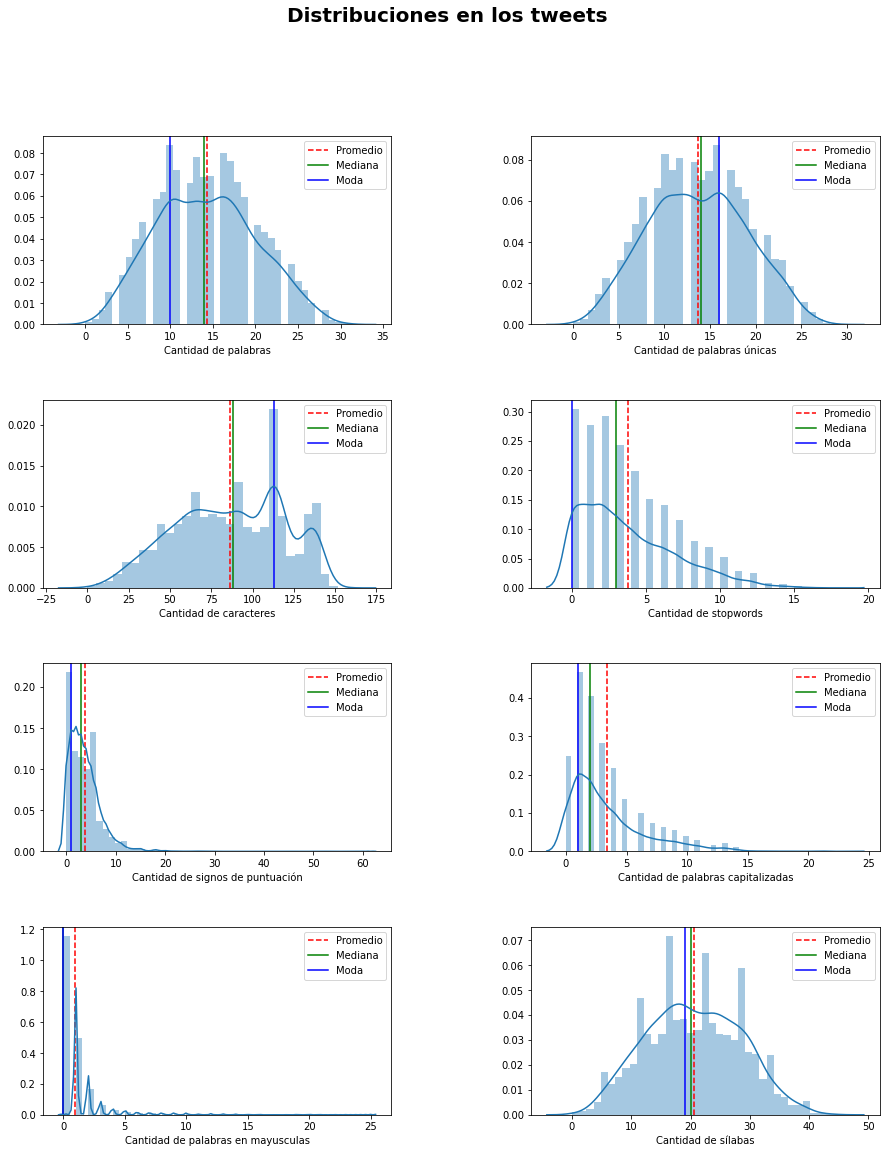

In [29]:
fig, axes = plt.subplots(4,2, figsize = (15,18))
plt.subplots_adjust( wspace =0.4, hspace = 0.4)
plt.suptitle("Distribuciones en los tweets", fontsize =20, fontweight = 'bold')

for i in range(len(palabras_col)):

    ax = plt.subplot(4,2,i+1)
    
    mean=palabras[palabras_col[i]].mean()
    median=palabras[palabras_col[i]].median()
    mode=palabras[palabras_col[i]].mode()[0]

    ax.axvline(mean, color='r', linestyle='--')
    ax.axvline(median, color='g', linestyle='-')
    ax.axvline(mode, color='b', linestyle='-')

    sns.distplot(palabras[palabras_col[i]], axlabel = palabras_nombre_col[i])
    
    plt.legend({'Promedio':mean,'Mediana':median, 'Moda':mode})
    

plt.show()

Gráfico boxplot de data sobre los tweets

Gráfico de distribuciones de data sobre los tweets según veracidad

In [ ]:
fig, axes = plt.subplots(4,2, figsize = (15,18))
plt.subplots_adjust(wspace =0.4, hspace = 0.4)
plt.suptitle("Distribución de densidad de palabras en tweets verdaderos y falsos", fontsize =20, fontweight = 'bold', y=0.92)

for i in range(len(palabras_col)):
    plt.subplot(4,2,i+1)
    sns.distplot(palabras.loc[palabras.target==False][palabras_col[i]], color="red", label='Tweet Falso')
    sns.distplot(palabras.loc[palabras.target==True][palabras_col[i]], axlabel = palabras_nombre_col[i], color="green", label = 'Tweet Verdadero')
    plt.legend()

plt.show()

Analizo las distribuciones para cada los tweets reales y falsos por separado

In [ ]:
fig, axes = plt.subplots(4,2, figsize = (15,18))
plt.subplots_adjust( wspace =0.4, hspace = 0.4)
plt.suptitle("Distribuciones cuantitativas en los tweets\nsegún veracidad", fontsize =20, fontweight = 'bold',y=0.94)

sns.set(style="ticks", palette="pastel")

for i in range(len(palabras_col)):

    plt.subplot(4,2,i+1)
    g = sns.boxplot(x="target", y=palabras_col[i], palette=["r", "g"],
            data=palabras)
    sns.despine(offset=10, trim=True)
    g.set(ylabel= palabras_nombre_col[i])
    g.set(xlabel= "Tweet")
    g.set(xticklabels= ["Falso", "Real"])

plt.show()

### 1.2 Wordclouds: lo más usual en cada categoría

In [ ]:
palabras_nombre_col = ["Todas las palabras", "Palabras únicas", "palabras minúsculas",\
                       "Palabras MAYUSCULAS","Palabras Capitalizadas"]
string_palabras = [""]*len(palabras_nombre_col)

In [ ]:
palabras = train[["target"]].copy()
palabras['text'] = train['text'].apply(lambda x: quitar_mencion_twitter(quitar_link_twitter(x)))

palbras_list = [palabras]

for tweet in palabras['text']:
    
    text =  tweet.split()
        
    # palabras Capitalizadas
    string_palabras[4] += (" ").join(title(tweet)) + " "
    
    # palabras MAYUSCULA
    string_palabras[3] += (" ").join(upper_list(tweet)) + " "
    
    # Palabras minusculas
    string_palabras[2] +=  (" ").join(lower_list(tweet)) + " "
    
    # Aplico lower case y saco stopwords
    tweet = tweet.lower()

    # Palabras
    string_palabras[0] += tweet + " "

    # palabras únicas
    string_palabras[1] += (" ").join(set(text)) + " "


In [ ]:
tweet_images = ["T.png", "W-2.jpg","E.png","E.png","T.png"]

In [ ]:
fig, axes = plt.subplots(1,5, figsize = (80,50), gridspec_kw={'width_ratios': [1, 1.7, 1, 1, 1]})
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.suptitle("Palabras más ocurrentes", fontsize = 70, fontweight='bold',y=0.67)

sns.set(style="ticks", palette="pastel")

for i in range(len(palabras_nombre_col)):
    axes[i].set_title(palabras_nombre_col[i], fontsize=60, y=-0.05)
    if ((i == 0) | (i == 4)):
        axes[i].set_title(palabras_nombre_col[i], fontsize=60, y=-0.11)
    if (i == 1):
        axes[i].set_title(palabras_nombre_col[i], fontsize=60, y=0.065)
    twitter_mask = imread(tweet_images[i])
    wordcloud = WordCloud(width =800, height=800,
                    background_color ='#FFFFFF', 
                    min_font_size = 8,
                    mask=twitter_mask, collocations=False).generate(string_palabras[i])

    axes[i].imshow(wordcloud)
    axes[i].axis('off')

plt.show()

## 2. Análisis carácteres especiales

In [ ]:
# Funciones auxiliares

def puntuacion_de_tw(tweet):
    res = []
    for w in tweet.split():
        if(w in string.punctuation):
            res.append(w)
    return (" ").join(res)

letras = "q w e r t y u i o a s d f g h j k l z x c v b n m".split()
letras_x3 = [c*3 for c in letras]
def tres_letras_de_tw(tweet):
    res = []
    for w in tweet.split():
        w = w.lower()        
        for trio in letras_x3:
            if(trio in w):
                res.append(w)
    return (" ").join(res)

punt= "` ~ ! @ # $ % ^ & * ( ) _ - + = | \ } ] { [ } " ' : ; ? / > . < , * / - + . ' " "
punct_x3 = [c*3 for c in punt]
def tres_punct_de_tw(tweet):
    res = []
    for w in tweet.split():
        w = w.lower()        
        for trio in punct_x3:
            if(trio in w):
                res.append(trio)
    return (" ").join(res)

emojis=[":)",":(","xd","Xd","XD","Dx","xd","Xd", "<3", "?)"]
def emojis_de_tw(tweet):
    res = []
    for w in tweet.split():
        if(len(w)<=2):
            for e in emojis:
                if(e in w):
                    res.append(e)
    return (" ").join(res)

def cant_puntos_suspensivos_tw(tweet):
    cant = 0
    for w in tweet.split():
        w = w.lower()        
        if "..." in w:
            cant+=1
    return cant

def cant_signos_de_pregunta_tw(tweet):
    cant = 0
    for w in tweet.split():
        w = w.lower()        
        if "???" in w:
            cant+=1
    return cant

def cant_signos_de_exclamacion_tw(tweet):
    cant = 0
    for w in tweet.split():
        w = w.lower()        
        if "!!!" in w:
            cant+=1
    return cant

In [ ]:
# Creo un dataframe para los caracteres
df_caracteres = palabras[["text",'target']].copy() #uso df palabras xq no tiene links

In [ ]:
# Agrego columnas a df_caracteres

df_caracteres["letrasx3"] = df_caracteres['text'].apply(lambda x: tres_letras_de_tw(x))
df_caracteres["puntuacion"] = df_caracteres['text'].apply(lambda x: puntuacion_de_tw(x))
df_caracteres["punctx3"] = df_caracteres['text'].apply(lambda x: tres_punct_de_tw(x))
df_caracteres["cant_punctx3"] = df_caracteres['punctx3'].apply(lambda x: len(x.split(" ")))
df_caracteres["cant..."] = df_caracteres['text'].apply(lambda x: cant_puntos_suspensivos_tw(x))
df_caracteres["cant???"] = df_caracteres['text'].apply(lambda x: cant_signos_de_pregunta_tw(x))
df_caracteres["cant!!!"] = df_caracteres['text'].apply(lambda x: cant_signos_de_exclamacion_tw(x))
df_caracteres["tiene_punt"] = df_caracteres['puntuacion'].apply(lambda x: x!="")

df_caracteres

In [ ]:
# Observo que no hay muchos emojis
df_caracteres['text'].apply(lambda x: emojis_de_tw(x)).value_counts()

### 2.1 Análsis de cantidad de caracteres especiales.

Analizo las apariciones de estos caracteres.

In [ ]:
dict_punct = {}
for s in df_caracteres[df_caracteres["puntuacion"]!=""]["puntuacion"]:
    if(s==" "):
        continue
    for w in s.split(" "):
        if w not in dict_punct:
            dict_punct[w] = 1
        else:
            dict_punct[w] +=1

In [ ]:
punct_keys = [k for k in dict_punct.keys()]
punct_vals = [v for v in dict_punct.values()]
index = [i+1 for i in range(len(punct_keys))]

In [ ]:
# selection sort

for i in range(len(punct_vals)): 
    min_idx = i 
    for j in range(i+1, len(punct_vals)): 
        if punct_vals[min_idx] > punct_vals[j]: 
            min_idx = j 
    punct_vals[i], punct_vals[min_idx] = punct_vals[min_idx], punct_vals[i]
    punct_keys[i], punct_keys[min_idx] = punct_keys[min_idx], punct_keys[i]       

In [ ]:
cant = 10
plt.hlines(y=index[cant:], xmin=0, xmax=punct_vals[cant:], color='skyblue')
plt.plot(punct_vals[cant:], index[cant:], "o", label=punct_vals[cant:])
 
# Add titles and axis names
plt.yticks(index[cant:], punct_keys[cant:])
plt.title("Cantidad de apariciones de\ntres signos de puntuación seguidos")
plt.xlabel('Cantidad de apariciones')
plt.ylabel('')

for i in range(len(punct_vals[cant:])):
    plt.text(punct_vals[cant:][i]+10, i+10.5, str(punct_vals[cant:][i]), c='r')

plt.show()

In [ ]:
df_caracteres["tiene_punt"].value_counts()

In [ ]:
g = sns.catplot(x="target", y="tiene_punt", data=df_caracteres,
                height=6, kind="bar", palette=['indianred','g'])
g.despine(left=True)
g.set(ylabel='Probabilidad de contener algún signo de puntuación', xlabel='Veracidad del tweet')
plt.title("Probabilidad de un tweet de contener algún signo de puntuación\nsegún su veracidad", loc='center', fontsize =14, fontweight = 'bold')

plt.show()

### 2.2 Análisis de la aparición de carácteres especiels tres veces o más seguidos

In [ ]:
cant_real = df_caracteres["punctx3"][df_caracteres["target"]==True].count()
cant_falso = df_caracteres["punctx3"][df_caracteres["target"]==False].count()
cant_sin_punt_real = df_caracteres["punctx3"][df_caracteres["target"]==True].value_counts()[0]
cant_sin_punt_falso = df_caracteres["punctx3"][df_caracteres["target"]==False].value_counts()[0]

division1 = [cant_falso, cant_real]
division2 = [cant_sin_punt_falso, cant_falso-cant_sin_punt_falso, cant_sin_punt_real, cant_real-cant_sin_punt_real]

Gráfico

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (5,5))

# pie exterior
plt.pie(division1, radius=1.5, startangle=90, autopct='%1.1f%%',\
        colors =["#451200", "#064e0a"], pctdistance=0.8,\
        textprops={'color':"w"})

# pie interior
plt.pie(division2, radius=1.5-0.5, startangle=90, autopct='%1.1f%%',\
        colors=["#b02c2c","#f44e4e","#388e3e","#94ce98"],\
        pctdistance=0.68)

# círculo blanco
circle = plt.Circle(xy=(0, 0), radius=0.5, facecolor='white')
plt.gca().add_artist(circle)


# legends
colors = ["#451200","#b02c2c","#f44e4e","#064e0a","#388e3e","#94ce98"]
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colors[i]) for i in range(len(colors))]
labels = ["tweets falsos:","sin signos","con signos",\
          "tweets verdaderos:","sin signos","con signos"]

plt.legend(handles, labels, loc=(1.2,0) , framealpha=1, frameon=False,)

# título
plt.title("Cantidad de tweets con\ntres signos de puntuación seguidos", y=1.1, fontsize =12, fontweight = 'bold')

plt.show()

Me fijo el número de ocurrencias de los carácteres de 3 signos en los tweets

In [ ]:
dict_punctx3 = {}
for s in df_caracteres[df_caracteres["punctx3"]!=""]["punctx3"]:
    for w in s.split(" "):
        if w not in dict_punctx3:
            dict_punctx3[w] = 1
        else:
            dict_punctx3[w] +=1

In [ ]:
punctx3_keys = [k for k in dict_punctx3.keys()]
punctx3_vals = [v for v in dict_punctx3.values()]
index = [i+1 for i in range(len(punctx3_keys))]

In [ ]:
# selection sort

for i in range(len(punctx3_vals)): 
    min_idx = i 
    for j in range(i+1, len(punctx3_vals)): 
        if punctx3_vals[min_idx] > punctx3_vals[j]: 
            min_idx = j 
    punctx3_vals[i], punctx3_vals[min_idx] = punctx3_vals[min_idx], punctx3_vals[i]
    punctx3_keys[i], punctx3_keys[min_idx] = punctx3_keys[min_idx], punctx3_keys[i]       

In [ ]:
plt.hlines(y=index, xmin=0, xmax=punctx3_vals, color='skyblue')
plt.plot(punctx3_vals, index, "o", label=punctx3_vals)
 
# Add titles and axis names
plt.yticks(index, punctx3_keys)
plt.title("Cantidad de apariciones de\ntres signos de puntuación seguidos")
plt.xlabel('Cantidad de apariciones')
plt.ylabel('')

for i in range(len(punctx3_vals)):
    plt.text(punctx3_vals[i], i+1, str(punctx3_vals[i]), c='r')

plt.show()

In [ ]:
df_caracteres[df_caracteres['cant...']!=0]['target'].value_counts()

In [ ]:
data_caracteres= df_caracteres.loc[:,['target','cant...','cant???','cant!!!']]
data_caracteres['cant...'] =df_caracteres['cant...']!=0 
data_caracteres['cant???'] =df_caracteres['cant???']!=0 
data_caracteres['cant!!!'] =df_caracteres['cant!!!']!=0 
data_caracteres.columns=['target','...','???','!!!']
data_caracteres= data_caracteres.groupby('target').agg({'...':'sum','???':'sum','!!!':'sum'})
data_caracteres = data_caracteres.stack().to_frame().reset_index()
data_caracteres.columns= ['veracidad_tweet','puntuacion','valores']

In [ ]:
data_caracteres['valores_1'] = (data_caracteres[data_caracteres['veracidad_tweet']==False]['valores']/4342)
data_caracteres['valores_2'] = data_caracteres[data_caracteres['veracidad_tweet']==True]['valores']/3271
data_caracteres = data_caracteres.fillna(0)
data_caracteres['valores'] = data_caracteres['valores_1'] + data_caracteres['valores_2']
data_caracteres = data_caracteres.loc[:,['veracidad_tweet','puntuacion','valores']]

In [ ]:
columns=['Veracidad del tweet', 'Signos de puntuación', 'Probabilidad de contener tres signos seguidos']
data_caracteres.columns = columns

sns.factorplot(x='Signos de puntuación', y='Probabilidad de contener tres signos seguidos', hue='Veracidad del tweet', data=data_caracteres, kind='bar', palette=["crimson","mediumseagreen"], height=6)
plt.title('Probabilidad de que un tweet contenga tres signos de puntuación seguidos\nsegún su veracidad',loc='center', fontsize =14, fontweight = 'bold')
plt.show()

### 2.3 Análisis de pronombre

In [ ]:
#funcion auxiliar

def count_word_tweet(tweet, words):
    cant = 0
    for w in tweet.lower().split(" "):
        if w in words:
            cant+=1
    return cant
def count_letter_tweet(tweet, char):
    cant = 0
    for words in tweet.lower().split(" "):
        for w in words:
            if char in w:
                cant+=1
    return cant

In [ ]:
# Creo un dataframe con la cantidad de pronombres personales

In [ ]:
df_pronombres = pd.DataFrame()

df_pronombres["target"] = train['target']

df_pronombres['she'] = train['text'].apply(lambda x: count_word_tweet(x, ["she", "she's"]))
df_pronombres['he'] = train['text'].apply(lambda x: count_word_tweet(x, ["he", "he's"]))
df_pronombres['it'] = train['text'].apply(lambda x: count_word_tweet(x, ["it", "it's"]))
df_pronombres['i'] = train['text'].apply(lambda x: count_word_tweet(x, ["i", "i'm"]))
df_pronombres['you'] = train['text'].apply(lambda x: count_word_tweet(x, ["you","you're"]))
df_pronombres['they'] = train['text'].apply(lambda x: count_word_tweet(x, ["they","they're"]))
df_pronombres['we'] = train['text'].apply(lambda x: count_word_tweet(x, ["we","we're"]))

In [ ]:
# Tomo solo los valores con pronombres
df_solo_pronombres = df_pronombres[df_pronombres.loc[:, df_pronombres.columns != 'target'].T.any()]

In [ ]:
cant_pronombres_falsos, cant_pronombres_reales = df_solo_pronombres.target.value_counts()

In [ ]:
cant_pronombres = df_solo_pronombres.count()[0]

In [ ]:
promedio_pronombre_falsos =(cant_pronombres_falsos/cant_pronombres)*100
promedio_pronombre_reales =(cant_pronombres_reales/cant_pronombres)*100

In [ ]:
data={'Reales: {:02.1f}%'.format(promedio_pronombre_reales): promedio_pronombre_reales,\
      'Falsos: {:02.1f}%'.format(promedio_pronombre_falsos): promedio_pronombre_falsos}
plt.figure(
    FigureClass=Waffle, 
    rows=10, 
    values=data, 
    colors=["green","#b02c2c"],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'fontsize':12},
    icons='dove', icon_size=14, 
    icon_legend=True
)
plt.title("Porcentaje de tweets con pronombres", loc='center', fontsize =12, fontweight = 'bold')
plt.show()

In [ ]:
train.target.value_counts()

In [ ]:
cant_sin_pronombres = train.count()[0]-cant_pronombres
cant_falsos, cant_reales = train.target.value_counts()

In [ ]:
promedio_pronombre_falsos =((cant_falsos-cant_pronombres_falsos)/cant_sin_pronombres)*100
promedio_pronombre_reales =((cant_reales-cant_pronombres_reales)/cant_sin_pronombres)*100

In [ ]:
data={'Reales: {:02.1f}%'.format(promedio_pronombre_reales): promedio_pronombre_reales,\
      'Falsos: {:02.1f}%'.format(promedio_pronombre_falsos): promedio_pronombre_falsos}
plt.figure(
    FigureClass=Waffle,
    rows=10,
    values=data,
    colors=["green","#b02c2c"],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0), 'fontsize':12},
    icons='user-slash', icon_size=14,
    icon_legend=True
)
plt.title("Porcentaje de tweets sin pronombres", loc='center', fontsize =12, fontweight = 'bold')
plt.show()

Se observa que 2457 de 7613 tweets poseen pronombres

In [ ]:
pronombres = ["she", "he", "it", "i","they", "you","we"]
N = len(pronombres)

In [ ]:
pronombres_cant = []
for i in range(len(pronombres)):
    pronombres_cant.append(sum(df_pronombres[pronombres[i]].value_counts()[1:]))

In [ ]:
squarify.plot(sizes=pronombres_cant, label=pronombres,\
              color = ["#4CB391","#d9e7c1", "#c1cdc1","#faebd7","#d6a49b","#fdd1a5", "#ffffbe"] )
plt.axis('off')
plt.title("Proporción de pronombres más usados", loc='center', fontsize =12, fontweight = 'bold')

plt.show()

In [ ]:
df_real_pronombres = df_pronombres[df_pronombres['target']==True]

pronombres_cant = []
for i in range(len(pronombres)):
    pronombres_cant.append(sum(df_real_pronombres[pronombres[i]].value_counts()[1:]))

    
perc = [str('{:5.2f}'.format(i/sum(pronombres_cant)*100)) + "%" for i in pronombres_cant]
lbl = [el[0].upper() + "\n" + el[1] for el in zip(pronombres, perc)]

fig = plt.figure(figsize=(12, 10))
ax = squarify.plot(sizes=pronombres_cant, label=lbl,\
              color = ["#4CB391","#d9e7c1", "#c1cdc1","#faebd7","#d6a49b","#fdd1a5", "#ffffbe"],
             )

plt.axis('off')
plt.title("Proporción de pronombres más usados en tweets reales", loc='center', fontsize =15, fontweight = 'bold')

plt.show()


In [ ]:
df_real_pronombres = df_pronombres[df_pronombres['target']==False]

pronombres_cant = []
for i in range(len(pronombres)):
    pronombres_cant.append(sum(df_real_pronombres[pronombres[i]].value_counts()[1:]))

perc = [str('{:5.2f}'.format(i/sum(pronombres_cant)*100)) + "%" for i in pronombres_cant]
lbl = [el[0].upper() + "\n" + el[1] for el in zip(pronombres, perc)]

fig = plt.figure(figsize=(12, 10))
squarify.plot(sizes=pronombres_cant, label=lbl,\
              color = ["#4CB391","#d9e7c1", "#c1cdc1","#faebd7","#d6a49b","#fdd1a5", "#ffffbe"] )
plt.axis('off')
plt.title("Proporción de pronombres más usados en tweets falsos", loc='center', fontsize =15, fontweight = 'bold')

plt.show()

In [ ]:
fig,axe = plt.subplots(figsize=(20, 5))

g = sns.heatmap(df_solo_pronombres.loc[:, df_solo_pronombres.columns != 'target'].T)
g.set(ylabel='Pronombres en inglés', xlabel='Tweets', xticks=[])
plt.title("Ocurrencias de los pronombres por tweet", loc='center', fontsize =14, fontweight = 'bold')

plt.show()

##  3. Análisis de hashtags

Funciones auxiliares:

In [ ]:
#limpio un poco el tweet
def cleanTweet(tweet):
    tw = " "
    words = tweet.split(' ')
    for word in words:
        word = ''.join(filter(lambda x: x in set(string.printable), word))
        word = word.replace("\n"," ")
        word = word.replace('û',"")
        word = word.replace('_','')
        word = word.replace("\"",'')
        word = word.strip('.')
        word = word.strip(',')
        word = word.strip(':')
        tw += word + " "
    return tw

'''Recibe un tweet en forma de string y devuelve otro string con sus hashtags con el separador ',' de por medio
y en minuscula.'''
def get_hashtags(tweet):
    res = ""
    words = tweet.split(' ')
    for word in words:
        if(word != "" and word[0]=='#'):
            res += word.lower() +" "
    return res[:-1]

'''Recibe un string y devuelve la cantidad de substrings que son separados por un delimitador ',' .'''
def cant_substrings(string):
    cant = 0
    delimiter =  '#'
    for c in string:
        if(c == delimiter):
            cant += 1
    return cant

Se crea un nuevo dataframe especialmente para los hashtags.

In [ ]:
df_hashtags = train[['id', 'text', 'target']].copy()
df_hashtags['text'] = df_hashtags['text'].apply(cleanTweet)
df_hashtags['hashtags'] = df_hashtags['text'].apply(get_hashtags).astype(str)
df_hashtags['cant_hashtags'] = df_hashtags['text'].apply(cant_substrings)

In [ ]:
df_hashtags_only = df_hashtags.loc[df_hashtags['hashtags']!='']
df_sin_hashtags = df_hashtags.loc[df_hashtags['hashtags']=='']

### 3.1 Cantidad de tweets con hashtags

Se calcula la cantidade de tweets con y sin hashtag.

In [ ]:
cant_tweets = df_hashtags.agg('count')[0]
cant_tweets_con_hashtag = df_hashtags_only.agg('count')[0]
cant_tweets_sin_hashtag = cant_tweets - cant_tweets_con_hashtag

In [ ]:
con_hashtag = round((cant_tweets_con_hashtag/cant_tweets)*100,1)
sin_hashtag = round((cant_tweets_sin_hashtag/cant_tweets)*100,1)
label_con_hashtag = str(con_hashtag)+'%'
label_sin_hashtag = str(sin_hashtag)+'%'

data={'Con Hashtags: '+label_con_hashtag: con_hashtag, 'Sin Hashtags: '+label_sin_hashtag: sin_hashtag}
plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=data, 
    colors=["#00acee","#b02c2c"],
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 0.7)},
    icons='hashtag', icon_size=14, 
    icon_legend=True,
    figsize=(10,10)
)
plt.title("Porcentaje de tweets con hashtags", loc='center', fontsize =12, fontweight = 'bold')
plt.show()

### 3.2 Hashtags más usados

Se genera un texto con todos los hashtags

In [ ]:
words = '' 
  
index = df_hashtags_only.index.tolist()
for i in index:
    words += df_hashtags_only.loc[i, "hashtags"] + " "

Se grafica de hashtags más usados usando un wordcloud

In [ ]:
twitter_mask = imread('twitter.png')

wordcloud = WordCloud(width = 2400, height = 2400, 
                background_color ='#00acee', 
                min_font_size = 7,
                mask=twitter_mask,
                colormap= "Pastel2", collocations=False).generate(words) 
  
plt.figure(figsize = (15, 15))
plt.title("HASHTAGS MÁS USADOS", loc='center', fontsize =20, fontweight = 'bold')
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Se crea un diccionario con los hashtags y su cantidad de apariciones en total.

In [ ]:
def get_df_cant_hashtags(df):
    
    dict_hashtag = {}
    for row in df["hashtags"]:
        hashtags = row.split(" ")
        for h in hashtags:
            if (len(h)>1):
                if(h in dict_hashtag):
                    dict_hashtag[h] += 1
                else:
                    dict_hashtag[h] = 1
    
    df_hashtags_ranking = pd.DataFrame.from_dict(dict_hashtag, orient ="index")
    df_hashtags_ranking.columns = ['cant']
    df_hashtags_ranking.sort_values("cant", ascending = False, inplace =True)
    
    return df_hashtags_ranking

In [ ]:
df_hashtags_ranking =  get_df_cant_hashtags(df_hashtags_only)

Se crea un ranking de los hashtags más usados.

In [ ]:
sns.set(style="white", context="talk")

top = 20
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))

labels = df_hashtags_ranking.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Blues_r", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Frecuencia")
ax1.set_xlabel("Hashtag")
ax1.set_xticklabels(labels, rotation = 80)
ax1.set_title("Top 20 hashtags más usados", loc='center', fontsize =20, fontweight = 'bold')

plt.show()

### 3.3  Hashtags mas usados en tweets falsos y reales

Observamos que auqellos tweets analizados sin hashtags son 58.87% falsos y 41.13% reales.

In [ ]:
df_sin_hashtags["target"].value_counts()

Separo por aquellos tweets con hashtag los reales de los falsos:

In [ ]:
df_hashtags_real = df_hashtags_only.loc[df_hashtags['target']==True]
df_hashtags_falso = df_hashtags_only.loc[df_hashtags['target']==False]

In [ ]:
df_hashtags_ranking_real =  get_df_cant_hashtags(df_hashtags_real)
df_hashtags_ranking_falso =  get_df_cant_hashtags(df_hashtags_falso)

In [ ]:
sns.set(style="white", context="talk")

top = 20
fig,axes = plt.subplots(2, 1, figsize=(10, 10))

plt.subplots_adjust(hspace = 0.75)
plt.suptitle("Top 20 hashtags más usados en tweets\nsegún veracidad", fontsize =20, fontweight = 'bold')

# Tweets reales
labels = df_hashtags_ranking_real.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking_real["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Greens_r", ax=axes[0])
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel("Frecuencia")
axes[0].set_xticklabels(labels, rotation = 70)
axes[0].set_title("Tweets reales", loc='center', fontsize =14)

# Tweets falsos

labels = df_hashtags_ranking_falso.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_hashtags_ranking_falso["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Reds_r", ax=axes[1])
axes[1].axhline(0, color="k", clip_on=False)
axes[1].set_ylabel("Frecuencia")
axes[1].set_xticklabels(labels, rotation = 70)
axes[1].set_title("Tweets falsos", loc='center', fontsize =14)

plt.show()

### 3.4 Análisis de cantidad de hashtags

In [ ]:
cant_sin_hashtags = df_sin_hashtags["target"].value_counts()

In [ ]:
cant_hashtags_falso = df_hashtags_ranking_falso["cant"].value_counts()
cant_hashtags_real = df_hashtags_ranking_real["cant"].value_counts()

In [ ]:
cant_hashtags_falsos_l =  [cant_sin_hashtags[0]]+cant_hashtags_falso[:2].tolist()\
+ [sum(cant_hashtags_falso[2:])]
cant_hashtags_real_l = [cant_sin_hashtags[1]]+cant_hashtags_real[:2].tolist()\
+ [sum(cant_hashtags_real[2:])]

In [ ]:
fig,ax1 = plt.subplots(1, 1, figsize=(15, 15))

barWidth = 0.3

r1 = np.arange(len(cant_hashtags_falsos_l))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, cant_hashtags_falsos_l, color='#B22222', width=barWidth, edgecolor='white', label='tweets falsos')
plt.bar(r2, cant_hashtags_real_l, color='#557f2d', width=barWidth, edgecolor='white', label='tweets verdaderos')
 
plt.xlabel('cantidad de hashtags')
plt.xticks([r + barWidth for r in range(len(cant_hashtags_falsos_l))], ['0', '1', '2', '3 o más'])

plt.ylabel('cantidad de tweets')
plt.yticks(range(0,3600,100))

plt.title("Cantidad de tweets con cierta cantidad de hashtags", fontweight = "bold", fontsize=16)
plt.grid(b=True, which='major', axis='y', color='#666660', linestyle='-', linewidth=0.5)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.legend()
plt.show()

### 3.5 Análisis de hashtags sobre catástrofes

In [ ]:
cant_hashtags_reales    = df_hashtags_only[df_hashtags_only['target']==True].id.count()
cant_tweets_reales      = df_hashtags[df_hashtags['target']==True].id.count()
cant_sin_hashtag_reales = df_sin_hashtags[df_sin_hashtags['target']==True].id.count()

cant_hashtags_falsos    = df_hashtags_only[df_hashtags_only['target']==False].id.count()
cant_tweets_falsos      = df_hashtags[df_hashtags['target']==False].id.count()
cant_sin_hashtag_falsos = df_sin_hashtags[df_sin_hashtags['target']==False].id.count()

In [ ]:
data = pd.DataFrame(
    {
        'labels': ['Con Hashtag', 'Sin Hashtag'],
        'Tweets sobre Catástrofes': [round((cant_hashtags_reales/cant_tweets_reales)*100,1), round((cant_sin_hashtag_reales/cant_tweets_reales)*100,1)],
        'Tweets Random': [round((cant_hashtags_falsos/cant_tweets_falsos)*100,1), round((cant_sin_hashtag_falsos/cant_tweets_falsos)*100,1)],
    },
).set_index('labels')

fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '311': {
            'values': data['Tweets sobre Catástrofes'],
            'labels': ["{0} ({1}%)".format(n, v) for n, v in data['Tweets sobre Catástrofes'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Tweets sobre Catástrofes', 'loc': 'left'}
        },
        '312': {
            'values': data['Tweets Random'],
            'labels': ["{0} ({1}%)".format(n, v) for n, v in data['Tweets Random'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.2, 1), 'fontsize': 8},
            'title': {'label': 'Tweets Random', 'loc': 'left'},
        },
    },
    rows=5,
    colors=("#2196f3", "#ff5252"),  # Default argument values for subplots
    figsize=(10, 5),  # figsize is a parameter of plt.figure
    icons='hashtag', icon_size=14, 
    icon_legend=True
)

## 4. Analisis de usuarios arrobados

In [ ]:
#Obtengo los strings con arrobas
def arrobas(tweet):
    res = ""
    words = tweet.split(' ')
    for word in words:
        if(word != "" and word[0]=='@'and len(word)>1):
            res += word +" "
    return res[:-1]

#Obtengo la cantidad de arrobados por tweet
def cantidad_arrobas(string):
    cantidad = 0
    delimiter = '@'
    for c in string:
        if(c == delimiter):
            cantidad += 1
    return cantidad

In [ ]:
df_arrobas = train[['id', 'text', 'target']].copy()
df_hashtags['text'] = df_hashtags['text'].apply(cleanTweet)
df_arrobas['arrobas'] = df_arrobas['text'].apply(arrobas).astype(str)
df_arrobas['cant_arrobas'] = df_arrobas['text'].apply(cantidad_arrobas)

In [ ]:
df_con_arrobas = df_arrobas.loc[df_arrobas['arrobas']!='']
df_sin_arrobas = df_arrobas.loc[df_arrobas['arrobas']=='']

### 4.1 Cantidad de tweets con usuarios arrobados

In [ ]:
cant_tweets = df_arrobas.agg('count')[0]
cant_tweets_con_arrobas = df_con_arrobas.agg('count')[0]
cant_tweets_sin_arrobas = cant_tweets - cant_tweets_con_arrobas

In [ ]:
data = [cant_tweets_con_arrobas, cant_tweets_sin_arrobas]
bars = ('Con arrobas(25,7%)','Sin arrobas(74.3%)')
y_pos = np.arange(len(bars))

fig, ax = plt.subplots()
ax.barh(y_pos, data)
ax.set_yticks(y_pos)
ax.set_yticklabels(bars)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Cantidad de tweets')
ax.set_title('Cantidad de tweets con o sin arrobas')
plt.show()

### 4.2 Top de usuarios arrobados

In [ ]:
def get_df_cant_arrobas(df):
    
    dict_arrobas = {}
    for row in df["arrobas"]:
        arrobas = row.split(" ")
        for a in arrobas:
            if(a in dict_arrobas):
                dict_arrobas[a] += 1
            else:
                dict_arrobas[a] = 1
    
    df_arrobas_ranking = pd.DataFrame.from_dict(dict_arrobas, orient ="index")
    df_arrobas_ranking.columns = ['cant']
    df_arrobas_ranking.sort_values("cant", ascending = False, inplace =True)
    
    return df_arrobas_ranking

In [ ]:
df_arrobas_ranking =  get_df_cant_arrobas(df_con_arrobas)

In [ ]:
sns.set(style="white", context="talk")

top = 20
fig,ax1 = plt.subplots(1, 1, figsize=(10, 5))

labels = df_arrobas_ranking.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_arrobas_ranking["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Oranges_r", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Frecuencia")
ax1.set_xticklabels(labels, rotation = 75)
ax1.set_title("Top 20 usuarios más arrobados", loc='center', fontsize =20, fontweight = 'bold')

plt.show()

### 4.3 Usuarios mas arrobados en tweets falsos y reales

In [ ]:
df_sin_arrobas_real = df_sin_arrobas.loc[df_arrobas['target']==True]
df_sin_arrobas_falso = df_sin_arrobas.loc[df_arrobas['target']==False]

In [ ]:
df_arrobas_real = df_con_arrobas.loc[df_arrobas['target']==True]
df_arrobas_falso = df_con_arrobas.loc[df_arrobas['target']==False]

In [ ]:
data_arrobas = train[['id','target']].copy()
data_arrobas['tweets_con_arrobas'] = df_con_arrobas['arrobas']
data_arrobas['tweets_sin_arrobas'] = df_sin_arrobas['cant_arrobas']
data_arrobas = data_arrobas.groupby('target').agg({'tweets_con_arrobas':['count'],'tweets_sin_arrobas':['count']}).reset_index()
data_arrobas.columns = ['target','cant_tweets_con_arrobas', 'cant_tweets_sin_arrobas']
data_arrobas['target'] = data_arrobas['target'].astype(str).astype(object)

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 3))

sns.set_color_codes("pastel")
sns.barplot(x="cant_tweets_sin_arrobas", y="target", data=data_arrobas,
            label="Sin usuarios arrobados", color=sns.xkcd_rgb["pale red"])

sns.set_color_codes("muted")
sns.barplot(x="cant_tweets_con_arrobas", y="target", data=data_arrobas,
            label="Con usuarios arrobados", color="g")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 3500), ylabel="",
       xlabel="Cantidad de tweets")
plt.title("Cantidad de tweets con o sin usuarios arrobados segun veracidad", fontweight= 'bold', fontsize=14)
sns.despine(left=True, bottom=True)

In [ ]:
df_arrobas_ranking_real =  get_df_cant_arrobas(df_arrobas_real)
df_arrobas_ranking_falso =  get_df_cant_arrobas(df_arrobas_falso)

In [ ]:
sns.set(style="white", context="talk")

top = 20
fig,axes = plt.subplots(2, 1, figsize=(10, 10))

plt.subplots_adjust(hspace = 1)
plt.suptitle("Top 20 menciones en tweets\nsegún veracidad", fontsize =20, fontweight = 'bold')

# Tweets reales
labels = df_arrobas_ranking_real.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_arrobas_ranking_real["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Greens_r", ax=axes[0])
axes[0].axhline(0, color="k", clip_on=False)
axes[0].set_ylabel("Frecuencia")
axes[0].set_xticklabels(labels, rotation = 75)
axes[0].set_title("Tweets reales", loc='center', fontsize =14)

# Tweets falsos

labels = df_arrobas_ranking_falso.index[:top]
x1 = [i for i in range(1,top+1)]
y1 = df_arrobas_ranking_falso["cant"][:top]

sns.barplot(x=x1, y=y1, palette="Reds_r", ax=axes[1])
axes[1].axhline(0, color="k", clip_on=False)
axes[1].set_ylabel("Frecuencia")
axes[1].set_xticklabels(labels, rotation = 75)
axes[1].set_title("Tweets falsos", loc='center', fontsize =14)

plt.show()

### 4.4 Analisis de cantidad de usuarios arrobados

In [ ]:
cant_sin_arrobas = df_sin_arrobas["target"].value_counts()
cant_arrobas_falso = df_arrobas_ranking_falso["cant"].value_counts()
cant_arrobas_real = df_arrobas_ranking_real["cant"].value_counts()

In [ ]:
cant_arrobas_falsos_l =  [cant_sin_arrobas[0]]+cant_arrobas_falso[:2].tolist()\
+ [sum(cant_arrobas_falso[2:])]
cant_arrobas_real_l = [cant_sin_arrobas[1]]+cant_arrobas_real[:2].tolist()\
+ [sum(cant_arrobas_real[2:])]

In [ ]:
fig,ax1 = plt.subplots(1, 1, figsize=(15, 15), dpi=80)

barWidth = 0.3

r1 = np.arange(len(cant_arrobas_falsos_l))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, cant_arrobas_falsos_l, color='#B22222', width=barWidth, edgecolor='white', label='tweets falsos')
plt.bar(r2, cant_arrobas_real_l, color='#557f2d', width=barWidth, edgecolor='white', label='tweets verdaderos')
 
plt.xlabel('Cantidad de arrobas')
plt.xticks([r + barWidth for r in range(len(cant_arrobas_falsos_l))], ['0', '1', '2', '3 o más'])

plt.ylabel('Cantidad de tweets')
plt.yticks(range(0,3500,100))

plt.title("Cantidad de tweets con cierta cantidad de arrobas", fontweight = "bold", fontsize=16)
plt.grid(b=True, which='major', axis='y', color='#666660', linestyle='-', linewidth=0.5)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.legend()
plt.show()

## 5. Tweets con links externos de twitter

In [ ]:
servidor ='http://t.co' #esel servidor de twitter 
# df_tweet_imagen = train.loc[(servidor in train["text"])]
# for tweet in train["text"]:
#    print(servidor in tweet)

In [ ]:
#comentario Dani: ojo que no todos los links son imagenes, aca un ejemplo

import requests

shorturl = 'http://t.co/LZmL1xB2nH'
url = requests.get(shorturl)

print("""
The shortened URL forwards to:

    %s
""" % url.url)

## 6. Análisis de Location

### 6.1 Análisis de valores nulos

In [ ]:
real_train_location = train.loc[train['target']==1]
real_train_location.head(1)

In [ ]:
fake_train_location = train.loc[train['target']==0]
fake_train_location.head(1)

In [ ]:
this_column = pd.Series(['type','location-null-values(%)','location-nonnull-values(%)','total'])
data = [['real', (real_train_location['location'].isnull().sum()/real_train_location['location'].count() * 100), \
         100 - ((real_train_location['location'].isnull().sum()/real_train_location['location'].count() * 100)), 100],\
        ['fake', (fake_train_location['location'].isnull().sum()/fake_train_location['location'].count() * 100),\
         100 - (fake_train_location['location'].isnull().sum()/fake_train_location['location'].count() * 100), 100]] 

location_null_vs_target = pd.DataFrame(data, columns = this_column)
location_null_vs_target

In [ ]:
plt.figure(figsize=(12, 12))

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(x="type", y="total", data=location_null_vs_target, label = "total", color="lightblue")
sns.barplot(x="type", y="location-null-values(%)", data=location_null_vs_target, label="null-values", color="black", alpha=.7)

plt.ylabel('Relacion entre tipo de tweets y null values en LOCATION ', fontsize=12, fontweight = 'semibold')
plt.xlabel('Tipo de tweet ', fontsize=12, fontweight = 'semibold')
plt.legend(ncol=2, loc="upper right", frameon=True)

sns.despine(left=True, bottom=True)

plt.show()

## 7. Análisis de keywords

In [ ]:
df_sin_keywords_nulos = train.dropna(subset=['keyword'])
df_disaster = train[train['target'] == 1]
df_not_disaster = df_sin_keywords_nulos[df_sin_keywords_nulos['target'] == 0]

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    wordList = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    s=' '
    return s.join(wordList) 

df_lemmatized = df_sin_keywords_nulos.copy()
df_lemmatized['keyword_lemmatized'] = df_sin_keywords_nulos.keyword.apply(lemmatize_text)
df_disaster_lemmatized = df_lemmatized[df_lemmatized['target'] == 1]
df_not_disaster_lemmatized = df_lemmatized[df_lemmatized['target'] == 0]

### 7.1 Análisis de keywords en tweets

In [ ]:
def toText(listOfWords):
    s=' '
    return s.join(listOfWords)

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict


def makeImage(text,bgd_color):
    wc = WordCloud(width=1600, height=800, background_color=bgd_color, max_words=1000)
    wc.generate_from_frequencies(text)

    plt.figure(figsize=(15,15))
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
df_keywords = df_lemmatized.keyword_lemmatized
makeImage(getFrequencyDictForText(toText(df_keywords)), 'white')

In [ ]:
df_by_keyword = df_lemmatized.loc[:,['keyword_lemmatized']]
df_by_keyword = df_by_keyword.groupby('keyword_lemmatized').agg({'keyword_lemmatized':'count'})
df_by_keyword.columns = ['cant']
df_by_keyword.sort_values('cant', inplace=True)
top20_keywords = df_by_keyword.tail(20)

In [ ]:
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top20_keywords.index, ymin=0, ymax=top20_keywords.cant, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=top20_keywords.index, y=top20_keywords.cant, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 20 palabras claves en tweets', fontdict={'size':22})
ax.set_ylabel('Cantidad de Tweets')
ax.set_xticks(top20_keywords.index)
ax.set_xticklabels(top20_keywords.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 90)

# Annotate
for row in top20_keywords.itertuples():
    ax.text(row.Index, row.cant+.5, s=round(row.cant, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

### 7.2 Análisis de keywords en tweets verdaderos

In [ ]:
disaster_keywords = df_disaster_lemmatized.keyword_lemmatized
makeImage(getFrequencyDictForText(toText(disaster_keywords)), 'black')

In [ ]:
df_disaster_by_keyword = df_disaster_lemmatized.loc[:,['keyword_lemmatized']]
df_disaster_by_keyword = df_disaster_by_keyword.groupby('keyword_lemmatized').agg({'keyword_lemmatized':'count'})
df_disaster_by_keyword.columns = ['cant']
df_disaster_by_keyword.sort_values('cant', inplace=True)
top20_disaster = df_disaster_by_keyword.tail(20)

In [ ]:
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top20_disaster.index, ymin=0, ymax=top20_disaster.cant, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=top20_disaster.index, y=top20_disaster.cant, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 20 palabras claves en tweets verdaderos', fontdict={'size':22})
ax.set_ylabel('Cantidad de Tweets')
ax.set_xticks(top20_disaster.index)
ax.set_xticklabels(top20_disaster.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 50)

# Annotate
for row in top20_disaster.itertuples():
    ax.text(row.Index, row.cant+.5, s=round(row.cant, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

### 7.3 Análisis de keywords en tweets falsos

In [ ]:
not_disaster_keywords = df_not_disaster_lemmatized.keyword_lemmatized
makeImage(getFrequencyDictForText(toText(not_disaster_keywords)),'lightcyan')

In [ ]:
df_not_disaster_by_keyword = df_not_disaster_lemmatized.loc[:,['keyword_lemmatized']]
df_not_disaster_by_keyword = df_not_disaster_by_keyword.groupby('keyword_lemmatized').agg({'keyword_lemmatized':'count'})
df_not_disaster_by_keyword.columns = ['cant']
df_not_disaster_by_keyword.sort_values('cant', inplace=True)
top20_not_disaster = df_not_disaster_by_keyword.tail(20)

In [ ]:
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top20_not_disaster.index, ymin=0, ymax=top20_not_disaster.cant, color='midnightblue', alpha=0.7, linewidth=2)
ax.scatter(x=top20_not_disaster.index, y=top20_not_disaster.cant, s=75, color='midnightblue', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 20 palabras claves en tweets falsos', fontdict={'size':22})
ax.set_ylabel('Cantidad de tweets')
ax.set_xticks(top20_not_disaster.index)
ax.set_xticklabels(top20_not_disaster.index, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 75)

# Annotate
for row in top20_not_disaster.itertuples():
    ax.text(row.Index, row.cant+.5, s=round(row.cant, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

In [ ]:
df_not_disaster_by_keyword = df_not_disaster_lemmatized[['id', 'keyword_lemmatized']].groupby('keyword_lemmatized').count()
df_not_disaster_by_keyword.sort_values('id', inplace=True)
df_not_disaster_by_keyword.reset_index(inplace=True)
top20_not_disaster = df_not_disaster_by_keyword.tail(20)
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top20_not_disaster.index, ymin=0, ymax=top20_not_disaster.id, color='midnightblue', alpha=0.7, linewidth=2)
ax.scatter(x=top20_not_disaster.index, y=top20_not_disaster.id, s=75, color='midnightblue', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 20 Palabras Claves en Tweets que no son sobre Catástrofes', fontdict={'size':22})
ax.set_ylabel('Cantidad de Tweets')
ax.set_xticks(top20_not_disaster.index)
ax.set_xticklabels(top20_not_disaster.keyword_lemmatized.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 78)

# Annotate
for row in top20_not_disaster.itertuples():
    ax.text(row.Index, row.id+.5, s=round(row.id, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

### Analisis de ocurrencias de palabras descartando articulos, preposiciones, pronombres, etc


In [ ]:
#metodo para analizar ocurrencias y cantidades
short_train = train[['id','text','target']]
a = short_train['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)

this_col = pd.Series(['word','frequency'])

rslt = pd.DataFrame(word_dist.most_common(1000),columns = this_col)

In [ ]:
rslt.iloc[950:955,]

# 8. CREACION DE TAGS PARA CADA TWEET

### 8.1 PROCESAMIENTO DE ARCHIVOS .txt PARA EL ARMADO DE UNA LISTA AMPLIA DE STOPWORDS


In [ ]:
archivo_1 = open("99webtools.txt", "r")
listaPalabras_1 = []

for line in archivo_1:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_1. append(line_list)
archivo_1. close()

In [ ]:
archivo_2 = open("atire_ncbi.txt", "r")
listaPalabras_2 = []

for line in archivo_2:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_2. append(line_list)
archivo_2. close()

In [ ]:
archivo_3 = open("atire_puurula.txt", "r")
listaPalabras_3 = []

for line in archivo_3:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_3. append(line_list)
archivo_3. close()

In [ ]:
archivo_4 = open("azure.txt", "r")
listaPalabras_4 = []

for line in archivo_4:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_4. append(line_list)
archivo_4. close()

In [ ]:
archivo_5 = open("bbalet.txt", "r")
listaPalabras_5 = []

for line in archivo_5:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_5. append(line_list)
archivo_5. close()

In [ ]:
archivo_6 = open("bow_short.txt", "r")
listaPalabras_6 = []

for line in archivo_6:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_6. append(line_list)
archivo_6. close()

In [ ]:
archivo_7 = open("choi_2000naacl.txt", "r")
listaPalabras_7 = []

for line in archivo_7:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_7. append(line_list)
archivo_7. close()

In [ ]:
archivo_8 = open("cook1988_function_words.txt", "r")
listaPalabras_8 = []

for line in archivo_8:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_8. append(line_list)
archivo_8. close()

In [ ]:
archivo_9 = open("corenlp_acronym.txt", "r")
listaPalabras_9 = []

for line in archivo_9:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_9. append(line_list)
archivo_9. close()

In [ ]:
archivo_10 = open("corenlp_hardcoded.txt", "r",encoding="utf8")
listaPalabras_10 = []

for line in archivo_10:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_10. append(line_list)
archivo_10. close()

In [ ]:
archivo_11 = open("corenlp_stopwords.txt", "r")
listaPalabras_11 = []

for line in archivo_11:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_11. append(line_list)
archivo_11. close()

In [ ]:
archivo_12 = open("datasciencedojo.txt", "r")
listaPalabras_12 = []

for line in archivo_12:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_12. append(line_list)
archivo_12. close()

In [ ]:
archivo_13 = open("deeplearning4j.txt", "r")
listaPalabras_13 = []

for line in archivo_13:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_13. append(line_list)
archivo_13. close()

In [ ]:
archivo_14 = open("dkpro.txt", "r")
listaPalabras_14 = []

for line in archivo_14:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_14. append(line_list)
archivo_14. close()

In [ ]:
archivo_15 = open("mongodb.txt", "r")
listaPalabras_15 = []

for line in archivo_15:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_15. append(line_list)
archivo_15. close()

In [ ]:
archivo_16 = open("galago_inquery.txt", "r")
listaPalabras_16 = []

for line in archivo_16:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_16. append(line_list)
archivo_16. close()

In [ ]:
archivo_17 = open("gate_keyphrase.txt", "r")
listaPalabras_17 = []

for line in archivo_17:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_17. append(line_list)
archivo_17. close()

In [ ]:
archivo_18 = open("gensim.txt", "r")
listaPalabras_18 = []

for line in archivo_18:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_18. append(line_list)
archivo_18. close()

In [ ]:
archivo_19 = open("glasgow_stop_words.txt", "r")
listaPalabras_19 = []

for line in archivo_19:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_19. append(line_list)
archivo_19. close()

In [ ]:
archivo_20 = open("indri.txt", "r")
listaPalabras_20 = []

for line in archivo_20:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_20. append(line_list)
archivo_20. close()

In [ ]:
archivo_21 = open("kevinbouge.txt", "r")
listaPalabras_21 = []

for line in archivo_21:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_21. append(line_list)
archivo_21. close()

In [ ]:
archivo_22 = open("lexisnexis.txt", "r")
listaPalabras_22 = []

for line in archivo_22:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_22. append(line_list)
archivo_22. close()

In [ ]:
archivo_23 = open("lingpipe.txt", "r")
listaPalabras_23 = []

for line in archivo_23:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_23. append(line_list)
archivo_23. close()

In [ ]:
archivo_24 = open("mallet.txt", "r")
listaPalabras_24 = []

for line in archivo_24:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_24. append(line_list)
archivo_24. close()

In [ ]:
archivo_25 = open("mysql_innodb.txt", "r")
listaPalabras_25 = []

for line in archivo_25:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_25. append(line_list)
archivo_25. close()

In [ ]:
archivo_26 = open("mysql_myisam.txt", "r")
listaPalabras_26 = []

for line in archivo_26:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_26. append(line_list)
archivo_26. close()

In [ ]:
archivo_27 = open("galago_rmstop.txt", "r", encoding="utf8")
listaPalabras_27 = []

for line in archivo_27:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_27. append(line_list)
archivo_27. close()

In [ ]:
archivo_28 = open("atire_ncbi.txt", "r", encoding="utf8")
listaPalabras_28 = []

for line in archivo_28:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_28. append(line_list)
archivo_28. close()

In [ ]:
archivo_29 = open("galago_rmstop.txt", "r", encoding="utf8")
listaPalabras_29 = []

for line in archivo_29:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_29. append(line_list)
archivo_29. close()

In [ ]:
archivo_30 = open("nltk.txt", "r", encoding="utf8")
listaPalabras_30 = []

for line in archivo_30:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_30. append(line_list)
archivo_30. close()

In [ ]:
archivo_31 = open("okapiframework.txt", "r", encoding="utf8")
listaPalabras_31 = []

for line in archivo_31:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_31. append(line_list)
archivo_31. close()

In [ ]:
archivo_32 = open("okapi_cacm_expanded.txt", "r", encoding="utf8")
listaPalabras_32 = []

for line in archivo_32:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_32. append(line_list)
archivo_32. close()

In [ ]:
archivo_33 = open("onix.txt", "r", encoding="utf8")
listaPalabras_33 = []

for line in archivo_33:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_33. append(line_list)
archivo_33. close()

In [ ]:
archivo_34 = open("ovid.txt", "r", encoding="utf8")
listaPalabras_34 = []

for line in archivo_34:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_34. append(line_list)
archivo_34. close()

In [ ]:
archivo_35 = open("postgresql.txt", "r", encoding="utf8")
listaPalabras_35 = []

for line in archivo_35:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_35. append(line_list)
archivo_35. close()

In [ ]:
archivo_36 = open("pubmed.txt", "r", encoding="utf8")
listaPalabras_36 = []

for line in archivo_36:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_36. append(line_list)
archivo_36. close()

In [ ]:
archivo_37 = open("quanteda.txt", "r", encoding="utf8")
listaPalabras_37 = []

for line in archivo_37:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_37. append(line_list)
archivo_37. close()

In [ ]:
archivo_38 = open("r_tm.txt", "r", encoding="utf8")
listaPalabras_38 = []

for line in archivo_38:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_38. append(line_list)
archivo_38. close()

In [ ]:
archivo_39 = open("ranksnl_large.txt", "r", encoding="utf8")
listaPalabras_39 = []

for line in archivo_39:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_39. append(line_list)
archivo_39. close()

In [ ]:
archivo_40 = open("reuters_wos.txt", "r", encoding="utf8")
listaPalabras_40 = []

for line in archivo_40:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_40. append(line_list)
archivo_40. close()

In [ ]:
archivo_41 = open("rouge_155.txt", "r", encoding="utf8")
listaPalabras_41 = []

for line in archivo_41:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_41. append(line_list)
archivo_41. close()

In [ ]:
archivo_42 = open("scikitlearn.txt", "r", encoding="utf8")
listaPalabras_42 = []

for line in archivo_42:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_42. append(line_list)
archivo_42. close()

In [ ]:
archivo_43 = open("smart.txt", "r", encoding="utf8")
listaPalabras_43 = []

for line in archivo_43:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_43. append(line_list)
archivo_43. close()

In [ ]:
archivo_44 = open("snowball_expanded.txt", "r", encoding="utf8")
listaPalabras_44 = []

for line in archivo_44:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_44. append(line_list)
archivo_44. close()

In [ ]:
archivo_45 = open("spacy.txt", "r", encoding="utf8")
listaPalabras_45 = []

for line in archivo_45:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_45. append(line_list)
archivo_45. close()

In [ ]:
archivo_46 = open("spark_mllib.txt", "r", encoding="utf8")
listaPalabras_46 = []

for line in archivo_46:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_46. append(line_list)
archivo_46. close()

In [ ]:
archivo_47 = open("sphinx_mirasvit.txt", "r", encoding="utf8")
listaPalabras_47 = []

for line in archivo_47:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_47. append(line_list)
archivo_47. close()

In [ ]:
archivo_48 = open("t101_minimal.txt", "r", encoding="utf8")
listaPalabras_48 = []

for line in archivo_48:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_48. append(line_list)
archivo_48. close()

In [ ]:
archivo_49 = open("taporware.txt", "r", encoding="utf8")
listaPalabras_49 = []

for line in archivo_49:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_49. append(line_list)
archivo_49. close()

In [ ]:
archivo_50 = open("terrier.txt", "r", encoding="utf8")
listaPalabras_50 = []

for line in archivo_50:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_50. append(line_list)
archivo_50. close()

In [ ]:
archivo_51 = open("tonybsk_1.txt", "r", encoding="utf8")
listaPalabras_51 = []

for line in archivo_51:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_51. append(line_list)
archivo_51. close()

In [ ]:
archivo_52 = open("tonybsk_6.txt", "r", encoding="utf8")
listaPalabras_52 = []

for line in archivo_52:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_52. append(line_list)
archivo_52. close()

In [ ]:
archivo_53 = open("voyant_taporware.txt", "r", encoding="utf8")
listaPalabras_53 = []

for line in archivo_53:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_53. append(line_list)
archivo_53. close()

In [ ]:
archivo_54 = open("weka.txt", "r", encoding="utf8")
listaPalabras_54 = []

for line in archivo_54:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_54. append(line_list)
archivo_54. close()

In [ ]:
archivo_55 = open("xapian.txt", "r", encoding="utf8")
listaPalabras_55 = []

for line in archivo_55:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_55. append(line_list)
archivo_55. close()

In [ ]:
archivo_56 = open("xpo6.txt", "r", encoding="utf8")
listaPalabras_56 = []

for line in archivo_56:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_56. append(line_list)
archivo_56. close()

In [ ]:
archivo_57 = open("zettair.txt", "r", encoding="utf8")
listaPalabras_57 = []

for line in archivo_57:
    stripped_line = line. strip()
    line_list = stripped_line
    listaPalabras_57. append(line_list)
archivo_57. close()

In [ ]:
nueva_lista = list(itertools.chain(listaPalabras_1,listaPalabras_2,listaPalabras_3,listaPalabras_4,listaPalabras_5,listaPalabras_6,
                                  listaPalabras_7,listaPalabras_8,listaPalabras_9,listaPalabras_10,listaPalabras_11,listaPalabras_12,
                                  listaPalabras_13,listaPalabras_14,listaPalabras_15,listaPalabras_16,listaPalabras_17,listaPalabras_18,
                                  listaPalabras_19,listaPalabras_20,listaPalabras_21,listaPalabras_22,listaPalabras_23,listaPalabras_24,
                                  listaPalabras_25,listaPalabras_26,listaPalabras_27,listaPalabras_28,listaPalabras_29,listaPalabras_30,
                                  listaPalabras_31,listaPalabras_32,listaPalabras_33,listaPalabras_34,listaPalabras_35,listaPalabras_36,
                                  listaPalabras_37,listaPalabras_38,listaPalabras_39,listaPalabras_40,listaPalabras_41,listaPalabras_42,
                                  listaPalabras_43,listaPalabras_44,listaPalabras_45,listaPalabras_46,listaPalabras_47,listaPalabras_48,
                                  listaPalabras_49,listaPalabras_50,listaPalabras_51,listaPalabras_52,listaPalabras_53,listaPalabras_54,
                                   listaPalabras_55, listaPalabras_56,listaPalabras_57))

In [ ]:
#LIMPIEZA DE LA LISTA CREADA A PARTIR DE LOS ARCHIVOS .txt
stopwords_large = []
for word in nueva_lista:
       if word not in stopwords_large:
          stopwords_large.append(word)
print(len(stopwords_large))

### 8.2 Limpieza de los campos para obtener tags

In [ ]:
short_train = train[['id','text','target']].copy(deep=True)
short_train

In [ ]:
short_train['new'] = short_train.text.apply(lambda x: x.lower())

short_train.new.replace('\d+', '', regex=True, inplace=True)

invalid_chars = ['#','|','@','!','?','-','_','[',']','%','&',':','.',',',"''",'/','https','(','//t',')','http',
                 ';','#']

def removeInvalidChars(string):
    for char in invalid_chars:
        if char in string:
            string = string.replace(char,' ')
    return string

def removeUrlAndTags(string):
    string = re.sub(r"(?:\@|https?\://)\S+", " ",  string)
    return string

short_train.new = short_train.new.apply(removeUrlAndTags)
short_train.new = short_train.new.apply(removeInvalidChars)

In [ ]:
short_train

### 8.3 Eliminacion de terminos, caracteres y stopwords innecesarios para generar los tags

In [ ]:
def prettify(word_list):
    wl = []
    for word in word_list:
        word = re.sub(r'[^A-Za-z]', " ",  word)
        word = re.sub(r'\b\w\b',' ', word)
        word = re.sub(r'\s+', ' ', word)
        wl.append(word.strip())
    return wl

In [ ]:
#deep copy
short_train2 = short_train[['id','text','new','target']].copy(deep=True)

#convierte de list a string
short_train2['new'] = short_train2['new'].apply(lambda x: [item for item in x.split() if item not in stopwords_large])

#short_train2['new'] = short_train2.new.astype(str).str.replace('\[|\]|\'', '')

#short_train2.new = short_train2.new.apply(lambda x: x.replace(',',''))
#short_train2.new = short_train2.new.apply(lambda x: x.replace('"',''))
#short_train2.new = short_train2.new.apply(lambda x: x.replace("'",''))

#elimina todas las letras sueltas
#short_train2.new.str.replace(r'\b\w\b','').str.replace(r'\s+', '')

#elimina todos los numeros
#short_train2.new.replace('\d+', '', regex=True, inplace=True)

short_train2.new = short_train2.new.apply(prettify)
short_train2.head(13)

### 8.4 Tokenization

In [ ]:
#tokenize
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(word_list):
    text = ' '
    text = text.join(word_list)
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

short_train2['new_tokenized'] = short_train2.new.apply(lemmatize_text)

#convierte de list a string
#short_train2['new_new_tokenized'] = short_train2.new_tokenized.astype(str).str.replace('\[|\]|\'', '')

#short_train2.new_new_tokenized = short_train2.new_new_tokenized.apply(lambda x: x.replace(',',''))
#short_train2.new_new_tokenized = short_train2.new_new_tokenized.apply(lambda x: x.replace('"',''))
#short_train2.new_new_tokenized = short_train2.new_new_tokenized.apply(lambda x: x.replace("'",''))

#elimina todos los numeros
#short_train2.new_new_tokenized.replace('\d+', '', regex=True, inplace=True)

#elimina todas las letras sueltas
#short_train2.new_new_tokenized.str.replace(r'\b\w\b','').str.replace(r'\s+', '')

short_train2.new_tokenized = short_train2.new_tokenized.apply(prettify)
short_train2.head(13)

### 8.5 Analisis de ocurrencias y cantidades

In [ ]:
def getText(word_list):
    text = ' '
    text = text.join(word_list)
    return text

#metodo para analizar ocurrencias y cantidades
a = short_train2['new_tokenized'].apply(getText).str.lower().str.cat(sep=' ')

words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)

this_col = pd.Series(['word','frequency'])

rslt = pd.DataFrame(word_dist.most_common(400),columns = this_col)

In [ ]:
rslt.iloc[0:10,]

In [ ]:
frequent_words = rslt ['word']
nuevo = set(frequent_words)

### Se genera columna con tags a partir de una cantidad de ocurrencias destacadas

In [ ]:
def word_finder(x):
    x = set(x)
    return list(nuevo.intersection(x))

short_train2['tags'] = short_train2.new_tokenized.apply(word_finder)
train_and_tags = short_train2[['id','target','text','tags']]
train_and_tags

# 9. CALCULO DE PROBABILIDAD DE VERACIDAD PARA CIERTO TAG

### 9.1 Tagging para tweets reales y falsos por separado

In [ ]:
short_train2_int = short_train2[['id','new_tokenized','target']]
short_train2_int

In [ ]:
short_train2_real = short_train2_int[short_train2_int['target']==True]
short_train2_real.head()

In [ ]:
short_train2_fake = short_train2_int[short_train2_int['target']==False]
short_train2_fake.head()

In [ ]:
#metodo para analizar ocurrencias y cantidades para tweets reales
a = short_train2_real['new_tokenized'].apply(getText).str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)

this_col = pd.Series(['word','frequency'])

high_freq_real = pd.DataFrame(word_dist.most_common(400),columns = this_col)
high_freq_real.head(1)

In [ ]:
#metodo para analizar ocurrencias y cantidades para tweets falsos
a = short_train2_fake['new_tokenized'].apply(getText).str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print (word_dist)

this_col = pd.Series(['word','frequency'])

high_freq_fake = pd.DataFrame(word_dist.most_common(400),columns = this_col)
high_freq_fake.head(1)

In [ ]:
#mergeamos los dataframes
real_vs_fake_freq = pd.merge(high_freq_real , high_freq_fake, on = 'word')
real_vs_fake_freq.head(1)

In [ ]:
#renombre de columnas
real_vs_fake_freq.columns = ['tag','#real_tweets','#fake_tweets']
real_vs_fake_freq.head(1)

In [ ]:
#anadimos columna total
real_vs_fake_freq['total'] = real_vs_fake_freq['#real_tweets'] + real_vs_fake_freq['#fake_tweets']
real_vs_fake_freq.head(1)

In [ ]:
real_vs_fake_freq['prob_veracidad'] = real_vs_fake_freq['#real_tweets']/real_vs_fake_freq['total']
real_vs_fake_freq.head(1)

In [ ]:
#me quedo con la columna q me interesa
probability_by_tag = real_vs_fake_freq[['tag','prob_veracidad']]
probability_by_tag.head(1)

In [ ]:
probability_by_tag_indexed = probability_by_tag.set_index('tag')

In [ ]:
probability_by_tag_indexed_bottom = probability_by_tag_indexed.sort_values('prob_veracidad')
probability_by_tag_indexed_bottom.head(1)

In [ ]:
probability_by_tag_indexed_top = probability_by_tag_indexed.sort_values('prob_veracidad', ascending = False)
probability_by_tag_indexed_top.head(1)

In [ ]:
#me quedo con los primeros 20 de cata dataframe
probability_by_tag_bottom_short = probability_by_tag_indexed_bottom.iloc[0:20,]
probability_by_tag_bottom_short.plot(kind='bar',figsize=(15,10), title = 'Probabilidad de veracidad de un tweet dado un tag',
                                    fontsize = 20)

In [ ]:
probability_by_tag_top_short = probability_by_tag_indexed_top.iloc[0:20,]
probability_by_tag_top_short.plot(kind = 'bar', figsize = (15,10), title = 'Probabilidad de veracidad de un tweet dado un tag',
                                 color = 'r', fontsize = 20)

In [ ]:
probability_by_tag_sliced = probability_by_tag.copy()
probability_by_tag_sliced['prob_period'] = pd.cut(probability_by_tag['prob_veracidad'], np.arange(0.6,1.1,0.05), right=True)
probability_by_tag_sliced = probability_by_tag_sliced.groupby('prob_period').agg({'tag':'count'}).reset_index()
probability_by_tag_sliced

In [ ]:
#df_sin_tags = short_train2[short_train2['tags']]
short_train_tags = short_train2.drop(columns=['new','new_tokenized'])
train_no_tags = short_train_tags[short_train2['tags'].map(lambda d: len(d)) == 0]
train_with_tags = short_train_tags[short_train2['tags'].map(lambda d: len(d)) > 0]

In [ ]:
train_no_tags

In [ ]:
train_with_tags

In [ ]:
data_tags = short_train_tags.copy()
data_tags['tweets_con_tags'] = train_with_tags['tags']
data_tags['tweets_sin_tags'] = train_no_tags['tags']
data_tags = data_tags.groupby('target').agg({'tweets_con_tags':['count'],'tweets_sin_tags':['count']}).reset_index()
data_tags.columns = ['target','cant_tweets_con_tags', 'cant_tweets_sin_tags']
data_tags['target'] = data_tags['target'].astype(str).astype(object)

In [ ]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(10, 3))

sns.set_color_codes("muted")
sns.barplot(x="cant_tweets_con_tags", y="target", data=data_tags,
            label="Con tags", color="g")
sns.set_color_codes("pastel")
sns.barplot(x="cant_tweets_sin_tags", y="target", data=data_tags,
            label="Sin tags", color=sns.xkcd_rgb["pale red"])

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 3500), ylabel="",
       xlabel="Cantidad de tweets")
plt.title("Cantidad de tweets con o sin tags segun veracidad", fontweight= 'bold', fontsize=14)
sns.despine(left=True, bottom=True)

In [ ]:
train_with_tags.tags.value_counts().head(10).to_frame()

In [ ]:
def toString(some_list):
    s = ','
    return s.join(some_list)

real_tags = train_with_tags[train_with_tags['target']==True].tags.apply(toString)
top10_real_tags = real_tags.value_counts().head(10).to_frame()
top10_real_tags
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top10_real_tags.index, ymin=0, ymax=top10_real_tags.tags, color='green', alpha=0.7, linewidth=2)
ax.scatter(x=top10_real_tags.index, y=top10_real_tags.tags, s=75, color='green', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 10 Tags en Tweets Verdaderos', fontdict={'size':22})
ax.set_ylabel('Cantidad de Tweets')
ax.set_xticks(top10_real_tags.index)
ax.set_xticklabels(top10_real_tags.index, rotation=40, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 30)

# Annotate
for row in top10_real_tags.itertuples():
    ax.text(row.Index, row.tags+.5, s=round(row.tags, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

In [ ]:
fake_tags = train_with_tags[train_with_tags['target']==False].tags.apply(toString)
top10_fake_tags = fake_tags.value_counts().head(10).to_frame()
top10_fake_tags
# Draw plot
fig, ax = plt.subplots(figsize=(14,7), dpi= 80)
ax.vlines(x=top10_fake_tags.index, ymin=0, ymax=top10_fake_tags.tags, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=top10_fake_tags.index, y=top10_fake_tags.tags, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Top 10 Tags en Tweets Falsos', fontdict={'size':22})
ax.set_ylabel('Cantidad de Tweets')
ax.set_xticks(top10_fake_tags.index)
#ax.set_xticklabels(top10_real_tags.keyword.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 30)

# Annotate
for row in top10_fake_tags.itertuples():
    ax.text(row.Index, row.tags+.5, s=round(row.tags, 2), horizontalalignment= 'center', verticalalignment='bottom', fontsize=14)

plt.show()

In [ ]:
#relacion entre cantidad de tags y veracidad tweet
short_train_tags['cant_tags'] = short_train_tags['tags'].apply(lambda x: len(x))
short_train_tags

In [ ]:
def get_df_cant_tags(df):
    
    dict_tag = {}
    for lista in df["tags"]:
        if (len(lista)>=1):
            if(len(lista) in dict_tag):
                dict_tag[len(lista)] += 1
            else:
                dict_tag[len(lista)] = 1
    
    df_tags_ranking = pd.DataFrame.from_dict(dict_tag, orient ="index")
    df_tags_ranking.columns = ['cant']
    df_tags_ranking.sort_values("cant", ascending = False, inplace =True)
    
    return df_tags_ranking

In [ ]:
cant_sin_tags= short_train_tags[short_train_tags['cant_tags'] == 0].target.value_counts()

df_tags_only = short_train_tags[short_train_tags['cant_tags'] != 0]

df_tags_real = df_tags_only.loc[short_train_tags['target'] == True]
df_tags_falso = df_tags_only.loc[short_train_tags['target'] == False]

df_tags_ranking_real = get_df_cant_tags(df_tags_real)
df_tags_ranking_falso = get_df_cant_tags(df_tags_falso)

cant_tags_falso = df_tags_ranking_falso["cant"].values.tolist()
cant_tags_real  = df_tags_ranking_real["cant"].values.tolist()

cant_tags_falsos_l =  [cant_sin_tags[0]]+cant_tags_falso[:6]\
                            + [sum(cant_tags_falso[6:])]
cant_tags_real_l = [cant_sin_tags[1]]+cant_tags_real[:6]\
                            + [sum(cant_tags_real[6:])]

In [ ]:
fig,ax1 = plt.subplots(1, 1, figsize=(12, 12))

barWidth = 0.3

r1 = np.arange(len(cant_tags_falsos_l))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, cant_tags_falsos_l, color='#B22222', width=barWidth, edgecolor='white', label='tweets falsos')
plt.bar(r2, cant_tags_real_l, color='#557f2d', width=barWidth, edgecolor='white', label='tweets verdaderos')
 
plt.xlabel('cantidad de tags')
plt.xticks([r + barWidth for r in range(len(cant_tags_falsos_l))], ['0', '1', '2', '3', '4', '5', '6', '7 o más'])

plt.ylabel('cantidad de tweets')
plt.yticks(range(0,2000,100))

plt.title("Cantidad de tweets con cierta cantidad de tags", fontweight = "bold", fontsize=16)

plt.legend()
plt.show()